In [37]:
!git clone https://github.com/MarkBridge11/RINE-extended

fatal: destination path 'RINE-extended' already exists and is not an empty directory.


In [38]:
import sys
sys.path.append('/content/RINE-extended')

In [39]:
!pip install scikit-image imageio opencv-python kornia git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ybtznuiz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ybtznuiz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [40]:
import sys
import os
from src.utils import get_transforms, get_our_trained_model
from PIL import Image
import torch
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, transforms, _ = get_transforms()
model = get_our_trained_model(ncls="ldm", device=device)
model.to(device).eval();

In [42]:
real_path = "/content/RINE-extended/demo/aadlygmazf.jpg"
real_image = Image.open(real_path).convert("RGB")
real_tensor = transforms(real_image).unsqueeze(0).to(device)
real_logit = model(real_tensor)[0]
real_probability = torch.sigmoid(real_logit)
print(
    f"real image - prob. to be fake: {real_probability.detach().cpu().numpy()[0][0]*100:1.1f}%"
)

real image - prob. to be fake: 35.6%


In [43]:
def get_token_importance(model, x): # should return the feature, per each transformer block, weighted by TIE
    # g = torch.stack([h.output for h in model.hooks], dim=2)[0]  # [tokens, blocks, dim]
    # g = model.proj1(g.float())  # same as in forward
    g = torch.stack([h.output for h in model.hooks], dim=2)  # [tokens, batch, blocks, dim]
    g = g[:,0,:,:]  # take batch=0 → [tokens, blocks, dim]
    g = model.proj1(g.float())  # same as forward

    # apply alpha weights
    weights = F.softmax(model.alpha, dim=1)[0]  # [blocks, dim]
    contrib = g * weights  # [tokens, blocks, dim]

    # # sum across feature dimension → relevance per token/block
    # contrib_map = contrib.sum(-1)  # [tokens, blocks]

    # # average over blocks → single importance score per token
    # token_scores = contrib_map.mean(-1)  # [tokens]

    #return token_scores.cpu().detach().numpy()
    return contrib.cpu().detach().numpy()

In [44]:
def map_to_image(block_map, image_size):
    heatmap = cv2.resize(block_map, image_size, interpolation=cv2.INTER_CUBIC)
    # normalize 0–1
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    return heatmap

In [45]:
def overlay_heatmap(img, heatmap, alpha=0.5):
    cmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cmap = cv2.cvtColor(cmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(np.array(img), 1 - alpha, cmap, alpha, 0)
    return overlay

In [46]:
contrib = get_token_importance(model, real_tensor)
contrib_map = np.linalg.norm(contrib, axis=-1) # shape: [tokens, blocks]
contrib_map = contrib_map[1:] # drop CLS
grid_size = int(np.sqrt(contrib_map.shape[0]))
#block_maps = contrib_map.reshape(grid_size, grid_size, -1)
block_maps = []
for b in range(contrib_map.shape[1]):
    block_map = contrib_map[:, b].reshape(grid_size, grid_size)
    block_maps.append(block_map)
block_maps = np.stack(block_maps)  # [blocks, grid, grid]

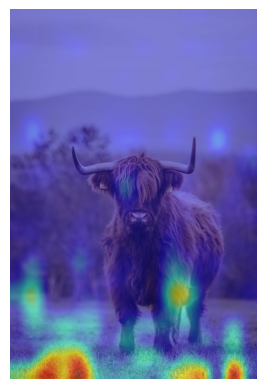

In [47]:
heatmap = map_to_image(block_maps[:,:,0], real_image.size)
overlay = overlay_heatmap(real_image, heatmap, alpha=0.5)

plt.imshow(overlay)
plt.axis("off")
plt.show()

In [48]:
# fake_path = "/content/RINE-extended/demo/zzrybysskm.jpg"
# fake_image = Image.open(fake_path).convert("RGB")
# fake_tensor = transforms(fake_image).unsqueeze(0).to(device)
# fake_logit = model(fake_tensor)[0]
# fake_probability = torch.sigmoid(fake_logit)
# print(
#     f"fake image - prob. to be fake: {fake_probability.detach().cpu().numpy()[0][0]*100:1.1f}%"
# )
